## Import libs and examples

In [1]:
import cv2 # https://docs.opencv.org/4.1.0/
import numpy as np
import matplotlib.pyplot as plt

from glob import iglob
from os.path import basename, splitext, join

In [2]:
# load image examples into a dictionary
examples = {}
for img_fname in iglob("i/*.png"):
    img_title = splitext(basename(img_fname))[0]
    img = cv2.imread(img_fname, cv2.IMREAD_COLOR)
    examples[img_title] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Improve display quality on the notebook
**Note:** although we'll set a higher dpi for showing images, there are still (many) artifacts introduced when seeing them inside the notebook, thus, you should always check the saved output in the `o/` folder.

In [28]:
%matplotlib inline

In [38]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # 150 to 300 are good values

## Show an image without changing it's pixel values for display
The image is saved as a .png file if `save_fname` is not the empty string.

In [3]:
def show(img, img_title="", save_fname="", save_path="o"):
    plt.axis('off')
    plt.title(img_title)
    plt.imshow(img, vmin=0, vmax=255, cmap="gray" if img.ndim == 2 else None)
    if save_fname:
        cv2.imwrite(join(save_path, save_fname + ".png"), img)

In [4]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [15]:
test_img_title = "baboon"
test_img = examples[test_img_title]
test_img.shape

(512, 512, 3)

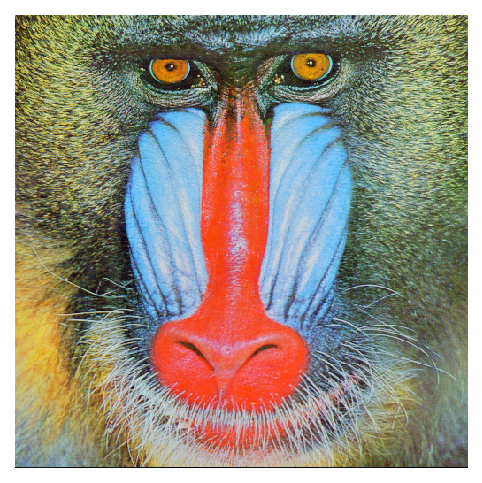

In [39]:
show(test_img)

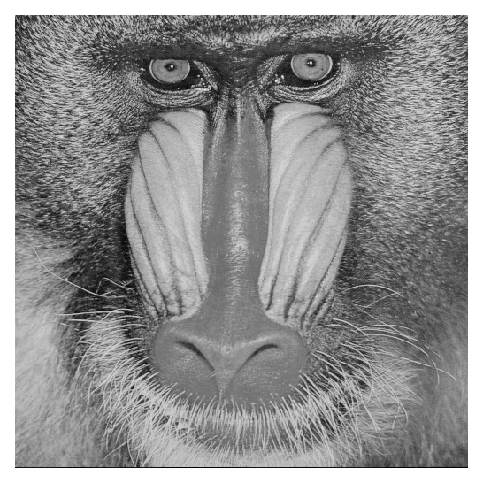

In [40]:
show(to_grayscale(test_img))

## Error diffusion techniques

In [8]:
class Technique:
    FLOYD_STEINBERG = "floyd_steinberg"
    STEVENSON_ARCE = "stevenson_arce"
    BURKES = "burkes"
    SIERRA = "sierra"
    STUCKI = "stucki"
    JARVIS_JUDICE_NINKE = "jarvis_judice_ninke"
    
    list_all = [FLOYD_STEINBERG, STEVENSON_ARCE, BURKES, SIERRA, STUCKI, JARVIS_JUDICE_NINKE]

In [9]:
DIFFUSION_MAP = {
    Technique.FLOYD_STEINBERG: [
                                        ( 1, 0, 7/16), 
        (-1, 1, 3/16),  ( 0, 1, 5/16),  ( 1, 1, 1/16)
    ],
    Technique.STEVENSON_ARCE: [
                                                  ( 2, 0, 32/200), 
        (-3, 1, 12/200), (-1, 1, 26/200), ( 1, 1, 30/200), ( 3, 1, 16/200), 
                (-2, 2, 12/200), ( 0, 2, 26/200), ( 2, 2, 12/200),  
        (-3, 3,  5/200), (-1, 3, 12/200), ( 1, 3, 12/200), ( 3, 3,  5/200)
    ],
    Technique.BURKES: [
                                                     ( 1, 0, 8/32), ( 2, 0, 4/32), 
        (-2, 1, 2/32), (-1, 1, 4/32), ( 0, 1, 8/32), ( 1, 1, 4/32), ( 2, 1, 2/32)
    ],
    Technique.SIERRA: [
                                                     ( 1, 0, 5/32), ( 2, 0, 3/32), 
        (-2, 1, 2/32), (-1, 1, 4/32), ( 0, 1, 5/32), ( 1, 1, 4/32), ( 2, 1, 2/32), 
                       (-1, 2, 2/32), (-1, 2, 3/32), ( 1, 2, 2/32)
    ],
    Technique.STUCKI: [
                                                     ( 1, 0, 8/42), ( 2, 0, 4/42), 
        (-2, 1, 2/42), (-1, 1, 4/42), ( 0, 1, 8/42), ( 1, 1, 4/42), ( 2, 1, 2/42), 
        (-2, 2, 1/42), (-1, 2, 2/42), ( 0, 2, 4/42), ( 1, 2, 2/42), ( 2, 2, 1/42)
    ],
    Technique.JARVIS_JUDICE_NINKE: [
                                                     ( 1, 0, 7/48), ( 2, 0, 5/48), 
        (-2, 1, 3/48), (-1, 1, 5/48), ( 0, 1, 7/48), ( 1, 1, 5/48), ( 2, 1, 3/48), 
        (-2, 2, 1/48), (-1, 2, 3/48), ( 0, 2, 5/48), ( 1, 2, 3/48), ( 2, 2, 1/48)
    ]
}

## a) Floyd e Steinberg

In [10]:
clamp = lambda v, min_v=0, max_v=255: min_v if v < min_v else max_v if v > max_v else v

In [11]:
''' Applies a dithering technique to the given grayscale image, returning a new halftone (black and white) image.
'''
def dither_gray(img, technique=Technique.FLOYD_STEINBERG, threshold=128):
    assert(technique in Technique.list_all), f"The dithering technique must be one of: {Technique.techniques}"
    assert(img.ndim == 2)
    dithered_img = img.copy()
    height, width = dithered_img.shape
        
    for x in range(width):
        for y in range(height):
            new_color = 0 if dithered_img[y, x] < threshold else 255
            diffusion_error = dithered_img[y, x] - new_color
            dithered_img[y, x] = new_color
            # error diffusion
            for dx, dy, weight in DIFFUSION_MAP[technique]:
                if 0 <= y+dy < height and 0 <= x+dx < width:
                    dithered_img[y+dy, x+dx] = clamp(dithered_img[y+dy, x+dx] + weight * diffusion_error)
    
    return dithered_img

In [25]:
technique = Technique.FLOYD_STEINBERG
dithered_test_img = dither_gray(to_grayscale(test_img), technique)

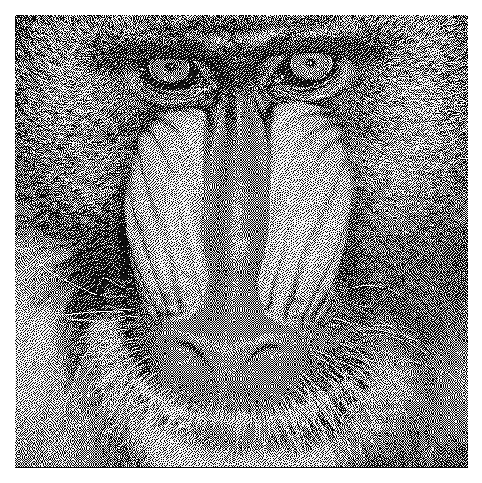

In [41]:
show(dithered_test_img, save_fname=f"{test_img_title} ({technique})")

In [14]:
# https://github.com/hbldh/hitherdither/blob/master/hitherdither/diffusion.py
# https://en.wikipedia.org/wiki/Dither#Algorithms
# https://en.wikipedia.org/wiki/Halftone